/tmp/ipykernel_235769/4251623901.py:184: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hot')


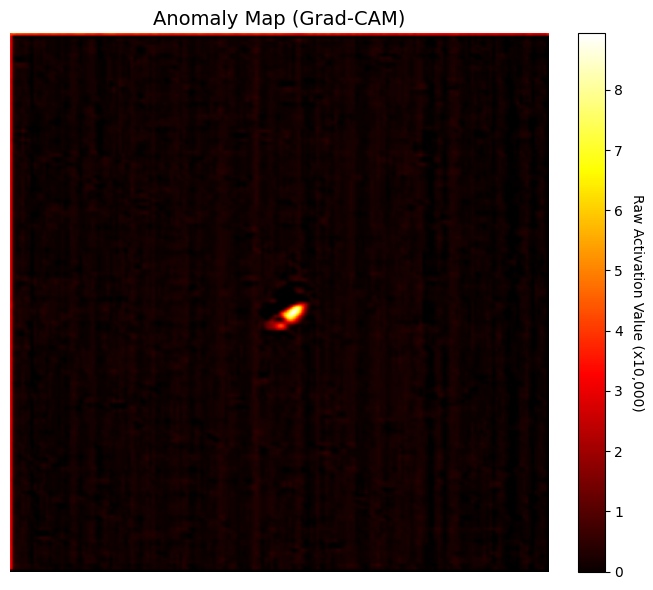

In [8]:
import os
import numpy as np
import cv2
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
from typing import Optional, Iterable
import captum.attr  # Ensure you have Captum installed: pip install captum

# --- Integrated GradCam Class ---
class GradCam(torch.nn.Module):
    def __init__(self, model: torch.nn.Module, name_layer: str, mean: list, std: list) -> None:
        super().__init__()
        self.model = model
        self.model.eval()
        
        # Extract the desired layer from the model.
        names_mid = name_layer.split(".")
        layer = model
        for name in names_mid:
            layer = getattr(layer, name)
        self.layer = layer
        
        # Captum's LayerGradCam
        self.cam = captum.attr.LayerGradCam(self._forward_only_logits, self.layer)
        
        # Mean/std for potential unnormalization
        self.mean = mean
        self.std  = std

    def _forward_only_logits(self, x: torch.Tensor) -> torch.Tensor:
        """Return only the logits from the model's output."""
        logits, _ = self.model(x)
        return logits

    def auto_select_indices(self, logits: torch.Tensor) -> torch.Tensor:
        """Select the top predicted class index for each sample."""
        return torch.argmax(logits, dim=1)
    
    def forward(
        self,
        x: torch.Tensor,
        indices: Optional[Iterable[int]] = None,
        with_upsample: bool = False
    ) -> torch.Tensor:
        """
        Returns raw Grad-CAM feature maps (float) of shape [B, 1, H, W] if with_upsample=True.
        """
        if indices is None:
            logits = self._forward_only_logits(x)
            indices = self.auto_select_indices(logits)

        x = x.requires_grad_(True)
        featuremaps = self.cam.attribute(x, target=indices, relu_attributions=True)
        
        if with_upsample:
            featuremaps = F.interpolate(
                featuremaps,
                size=x.shape[-2:],
                mode='bilinear',
                align_corners=True
            )
        return featuremaps  # shape [B, 1, H, W]
    
    @staticmethod
    def featuremaps_to_heatmaps(x: torch.Tensor) -> np.ndarray:
        """
        Applies per-sample min–max normalization and then uses cv2.applyColorMap(...)
        to generate a heatmap for each feature map.
        
        x: [B, 1, H, W]
        returns: [B, H, W, 3] in BGR format.
        """
        B, _, H, W = x.shape
        featuremaps = x.squeeze(1).detach().cpu().numpy()
        heatmaps = np.zeros((B, H, W, 3), dtype=np.uint8)

        for i_map, fmap in enumerate(featuremaps):
            # Normalize each sample to 0-255.
            hmap = cv2.normalize(fmap, None, 0, 255, cv2.NORM_MINMAX)
            hmap = cv2.applyColorMap(hmap.astype(np.uint8), cv2.COLORMAP_HOT)
            heatmaps[i_map] = hmap

        return heatmaps

# --- Data Loading Class ---
class BurgerData(Dataset):
    def __init__(self, imgSize: int, stride: int, image_folder: str, transform=None) -> None:
        super().__init__()
        self.imgSize = imgSize
        self.stride = stride
        self.image_folder = image_folder
        self.transform = transform

        # Use the first image found in the folder.
        self.image_path = None
        for f in os.listdir(image_folder):
            if f.endswith(('.png', '.jpg', '.jpeg')):
                self.image_path = os.path.join(image_folder, f)
                break

        if self.image_path is None:
            raise FileNotFoundError(f"No image found in {image_folder}")

    def __len__(self) -> int:
        return 1

    def __getitem__(self, index) -> torch.Tensor:
        if index != 0:
            raise IndexError("Index out of range for single-image dataset")
        img = Image.open(self.image_path).convert("RGB")
        if self.transform:
            img_tensor = self.transform(img)
        else:
            raise ValueError("Transform is not provided.")
        return img_tensor

# --- Main Code ---
if __name__ == "__main__":
    # Define normalization parameters.
    mean = [0.6047, 0.6183, 0.5254]
    std = [0.2732, 0.2820, 0.2739]
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    # Create the dataset (assumes one image in the folder).
    data = BurgerData(
        imgSize=256,
        stride=256,
        image_folder="/home/shn/data/Anomalies/black hole",  # Adjust path as needed.
        transform=transform
    )

    # Load image and move to GPU.
    img_tensor = data[0].unsqueeze(0).to("cuda")

    # --- Model Loading ---
    # Here we assume you have a model class `CutPaste` that can be loaded from a checkpoint.
    from train2 import CutPaste  # You can still import your model.
    checkpoint_path = "/home/shn/tb_logs/cutAndPaste/version_38/checkpoints/weights.ckpt"
    model = CutPaste.load_from_checkpoint(checkpoint_path=checkpoint_path).eval().to("cuda")

    # --- Grad-CAM Initialization ---
    grad_cam = GradCam(
        model.model,  # Assumes the actual model is inside model.model.
        "encoder.conv1",  # Ensure this layer exists in your model.
        mean=[0.5815, 0.5940, 0.5015],
        std=[0.2716, 0.2812, 0.2710]
    )

    # Compute Grad-CAM. Output shape: [B, 1, H, W].
    raw_featuremap = grad_cam.forward(img_tensor, indices=1, with_upsample=True)

    # --- Custom Heatmap Creation with Scaling ---
    # Extract raw activation values as a 2D array.
    raw_np = raw_featuremap.squeeze().detach().cpu().numpy()  # shape: [H, W]
    
    # Multiply the raw activation values by 10,000.
    scale_factor = 10000
    raw_np_scaled = raw_np * scale_factor

    # Compute the actual min and max of the scaled activations.
    fmin = raw_np_scaled.min()
    fmax = raw_np_scaled.max()

    # Normalize the scaled activations to [0, 1] using the actual range.
    raw_norm = (raw_np_scaled - fmin) / (fmax - fmin + 1e-8)
    # Scale to [0, 255] and convert to uint8.
    raw_uint8 = (raw_norm * 255).astype(np.uint8)

    # Apply colormap using OpenCV.
    heatmap_bgr = cv2.applyColorMap(raw_uint8, cv2.COLORMAP_HOT)
    heatmap_rgb = cv2.cvtColor(heatmap_bgr, cv2.COLOR_BGR2RGB)

    # Create a ScalarMappable for a colorbar that reflects [fmin, fmax].
    norm = mcolors.Normalize(vmin=fmin, vmax=fmax)
    cmap = cm.get_cmap('hot')
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])

    # --- Visualization ---
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(heatmap_rgb)
    ax.axis("off")
    ax.set_title("Anomaly Map (Grad-CAM)", fontsize=14)

    # Attach a colorbar showing the actual range of scaled raw activation values.
    cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Raw Activation Value (x10,000)", rotation=270, labelpad=15)
    cbar.ax.tick_params(labelsize=10)

    plt.tight_layout()
    plt.show()
